Tutorial 6: More Ray Tracing
============================

In this example, we'll reinforce what we learnt about ray-tracing in the last tutorial and introduce the following
new concepts:

1) That a _Tracer_ can be given any number of galaxies.

2) That by specifying redshifts and a cosmology, our results are converted to physical unit_label of
kiloparsecs (kpc).

In [1]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt

from astropy import cosmology

To begin, lets setup the _Grid_'s we 'll ray-trace using. Lets do something crazy, and use a higher resolution _Grid_ 
then before and set the sub _Grid_ size to 4x4 per pixel!

Every pixel is sub-gridded by 4x4, so the sub-grid has x16 more coordinates.

Lets also stop calling it the 'image_plane_grid', and just remember from now on our 'grid' is in the image-plane.

In [79]:
grid = al.Grid.uniform(shape_2d=(200, 200), pixel_scales=0.025, sub_size=4)

Every pixel is sub-gridded by 4x4, so the sub-grid has x16 more coordinates.

In [80]:
print(grid.sub_shape_2d)
print(grid.sub_shape_1d)

(800, 800)
640000


Next, lets setup a lens galaxy. In the previous tutorial, we set up each _Profile_ one line at a time. This made code 
long and cumbersome to read. This time we'll setup easy galaxy using one block of code. 
 

We'll also give the lens galaxy some attributes we didn't in the last tutorial:

    1) A _LightProfile_, meaning its light will appear in the image.
    2) An external shear, which accounts for the deflection of light due to line-of-sight structures.
    3) A redshift, which the _Tracer_ will use to convert arc second coordinates to kpc.

In [81]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    light=al.lp.SphericalSersic(
        centre=(0.0, 0.0), intensity=2.0, effective_radius=0.5, sersic_index=2.5
    ),
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), elliptical_comps=(0.0, -0.111111), einstein_radius=1.6
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.0)),
)

print(lens_galaxy)

Redshift: 0.5
Light Profiles:
SphericalSersic
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
intensity: 2.0
effective_radius: 0.5
sersic_index: 2.5
Mass Profiles:
EllipticalIsothermal
centre: (0.0, 0.0)
elliptical_comps: (0.0, -0.111111)
axis_ratio: 0.800000180000018
phi: 90.0
einstein_radius: 1.6
slope: 2.0
core_radius: 0.0
ExternalShear
centre: (0.0, 0.0)
elliptical_comps: (0.05, 0.0)
axis_ratio: 0.9047619047619047
phi: 45.0
magnitude: 0.05


Lets also create a small satellite galaxy nearby the lens galaxy and at the same redshift.

In [82]:
lens_satellite = al.Galaxy(
    redshift=0.5,
    light=al.lp.SphericalDevVaucouleurs(
        centre=(1.0, 0.0), intensity=2.0, effective_radius=0.2
    ),
    mass=al.mp.SphericalIsothermal(centre=(1.0, 0.0), einstein_radius=0.4),
)

print(lens_satellite)

Redshift: 0.5
Light Profiles:
SphericalDevVaucouleurs
centre: (1.0, 0.0)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
intensity: 2.0
effective_radius: 0.2
sersic_index: 4.0
Mass Profiles:
SphericalIsothermal
centre: (1.0, 0.0)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
einstein_radius: 0.4
slope: 2.0
core_radius: 0.0


Lets have a quick look at the appearance of our lens galaxy and its satellite.

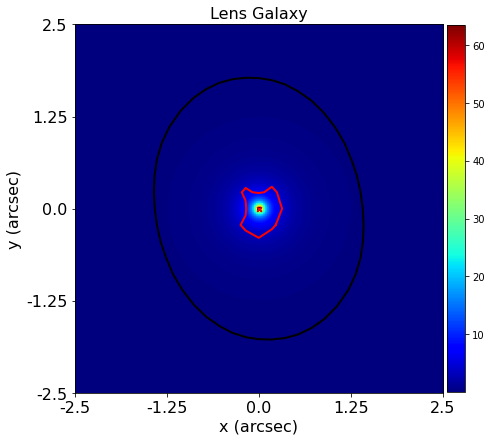

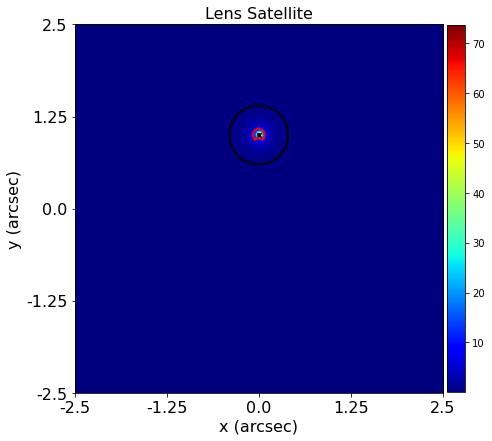

In [83]:
aplt.Galaxy.image(
    galaxy=lens_galaxy,
    grid=grid,
    plotter=aplt.Plotter(labels=aplt.Labels(title="Lens Galaxy")),
)

aplt.Galaxy.image(
    galaxy=lens_satellite,
    grid=grid,
    plotter=aplt.Plotter(labels=aplt.Labels(title="Lens Satellite")),
)

And their deflection angles - note that the satellite doesn't contribute as much to the deflections.

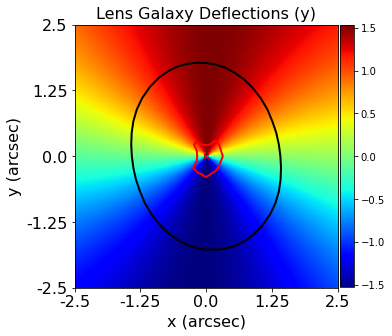

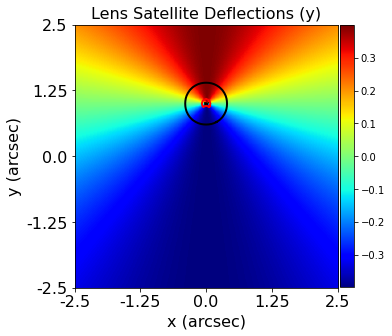

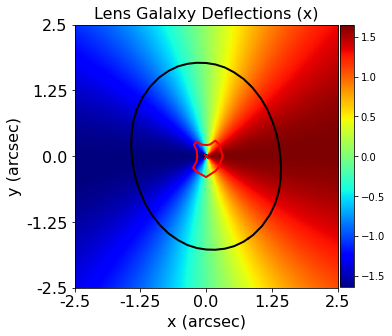

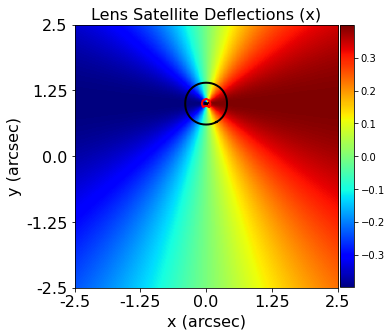

In [84]:
aplt.Galaxy.deflections_y(
    galaxy=lens_galaxy,
    grid=grid,
    plotter=aplt.Plotter(labels=aplt.Labels(title="Lens Galaxy Deflections (y)"), figure=aplt.Figure(figsize=(5, 5))),
)
aplt.Galaxy.deflections_y(
    galaxy=lens_satellite,
    grid=grid,
    plotter=aplt.Plotter(labels=aplt.Labels(title="Lens Satellite Deflections (y)"), figure=aplt.Figure(figsize=(5, 5))),
)
aplt.Galaxy.deflections_x(
    galaxy=lens_galaxy,
    grid=grid,
    plotter=aplt.Plotter(labels=aplt.Labels(title="Lens Galalxy Deflections (x)"), figure=aplt.Figure(figsize=(5, 5))),
)
aplt.Galaxy.deflections_x(
    galaxy=lens_satellite,
    grid=grid,
    plotter=aplt.Plotter(labels=aplt.Labels(title="Lens Satellite Deflections (x)"), figure=aplt.Figure(figsize=(5, 5))),
)

Now, lets make two source galaxies at redshift 1.0. Lets not use the terms 'light' and 'mass' to setup the light and 
_MassProfile_'s. Instead, lets use more descriptive names of what we think each component represents ( e.g. a 'bulge' 
and 'disk').

In [85]:
source_galaxy_0 = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.SphericalDevVaucouleurs(
        centre=(0.1, 0.2), intensity=0.3, effective_radius=0.3
    ),
    disk=al.lp.EllipticalExponential(
        centre=(0.1, 0.2),
        elliptical_comps=(0.111111, 0.0),
        intensity=3.0,
        effective_radius=2.0,
    ),
)

source_galaxy_1 = al.Galaxy(
    redshift=1.0,
    disk=al.lp.EllipticalExponential(
        centre=(-0.3, -0.5),
        elliptical_comps=(0.1, 0.0),
        intensity=8.0,
        effective_radius=1.0,
    ),
)

print(source_galaxy_0)
print(source_galaxy_1)

Redshift: 1.0
Light Profiles:
SphericalDevVaucouleurs
centre: (0.1, 0.2)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
intensity: 0.3
effective_radius: 0.3
sersic_index: 4.0
EllipticalExponential
centre: (0.1, 0.2)
elliptical_comps: (0.111111, 0.0)
axis_ratio: 0.800000180000018
phi: 45.0
intensity: 3.0
effective_radius: 2.0
sersic_index: 1.0
Redshift: 1.0
Light Profiles:
EllipticalExponential
centre: (-0.3, -0.5)
elliptical_comps: (0.1, 0.0)
axis_ratio: 0.8181818181818181
phi: 45.0
intensity: 8.0
effective_radius: 1.0
sersic_index: 1.0


Lets look at our source galaxies (before lensing)

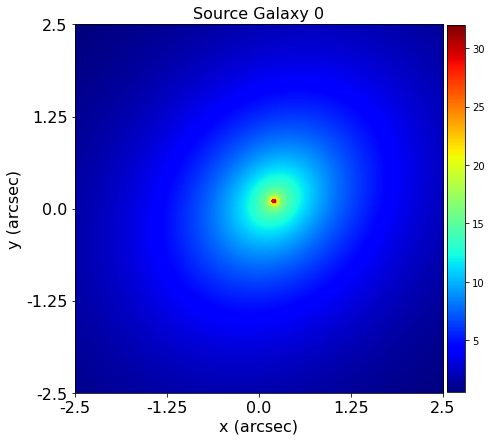

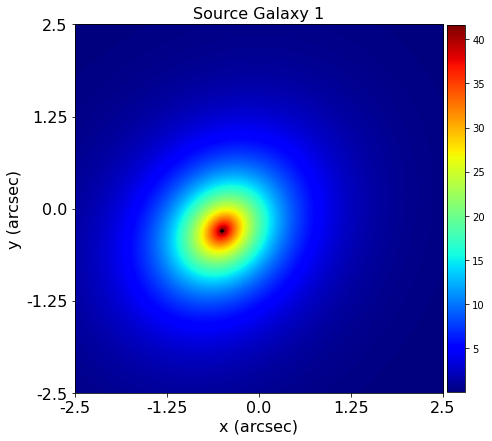

In [86]:
aplt.Galaxy.image(
    galaxy=source_galaxy_0,
    grid=grid,
    plotter=aplt.Plotter(labels=aplt.Labels(title="Source Galaxy 0")),
)

aplt.Galaxy.image(
    galaxy=source_galaxy_1,
    grid=grid,
    plotter=aplt.Plotter(labels=aplt.Labels(title="Source Galaxy 1")),
)


Now lets pass our 4 galaxies to the ray_tracing module, which means the following will occur:

    1) Using the galaxy redshift's, and image-plane and source-plane will be created with the appopriate galaxies.

Note that we've also supplied the _Tracer_ below with a Planck15 cosmology.

In [87]:
tracer = al.Tracer.from_galaxies(
    galaxies=[lens_galaxy, lens_satellite, source_galaxy_0, source_galaxy_1],
    cosmology=cosmology.Planck15,
)

We can next plot the tracer's _Profile_ image, which is compute as follows:

    1) First, using the image-plane _Grid_, the images of the lens galaxy and its satellite are computed.

    2) Using the _MassProfile_'s of the lens and satellite, their deflection angles are computed.

    3) These deflection angles are summed, such that the deflection of light due to every _MassProfile_ and both the lens galaxy and its satellite is computed.

    4) These deflection angles are used to trace every image-grid coordinate to a source-plane coordinate.

    5) The image of the source galaxies is computed by ray-tracing their light back to the image-plane.

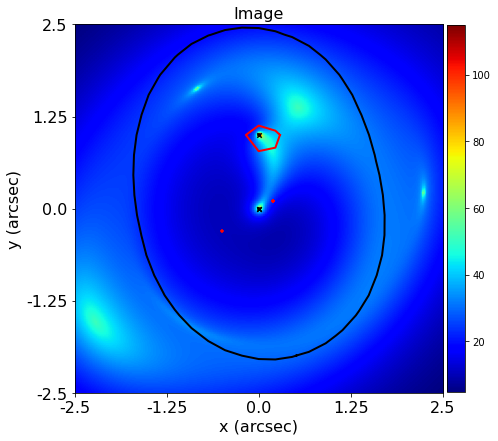

In [88]:
aplt.Tracer.image(tracer=tracer, grid=grid)

As we did previously, we can extract the _Grid_'s of each plane and inspect the source-plane grid.

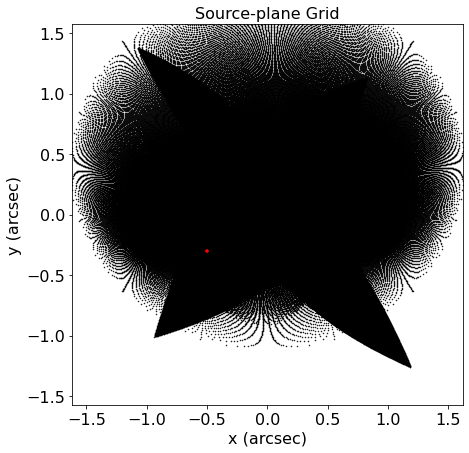

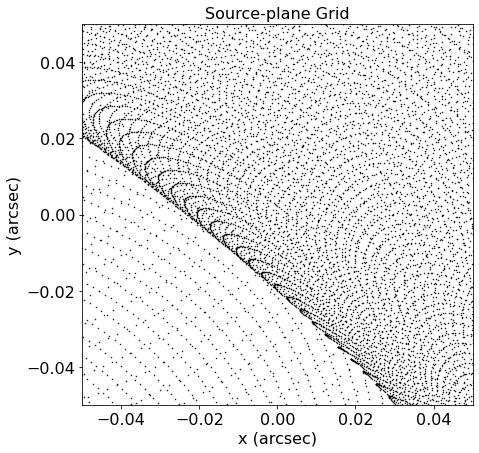

In [89]:
traced_grids = tracer.traced_grids_of_planes_from_grid(grid=grid)

aplt.Plane.plane_grid(
    plane=tracer.source_plane,
    grid=traced_grids[1],
    plotter=aplt.Plotter(labels=aplt.Labels(title="Source-plane Grid")),
)

plotter = aplt.Plotter(labels=aplt.Labels(title="Source-plane Grid"))

aplt.Plane.plane_grid(
    plane=tracer.source_plane,
    grid=traced_grids[1],
    axis_limits=[-0.05, 0.05, -0.05, 0.05],
    plotter=plotter,
)

Lets plot the lensing quantities again. Note that, because we supplied our galaxies with redshifts and our _Tracer_ with 
a cosmology, our units have been converted to kiloparsecs! (This cell can take a bit of time to run)

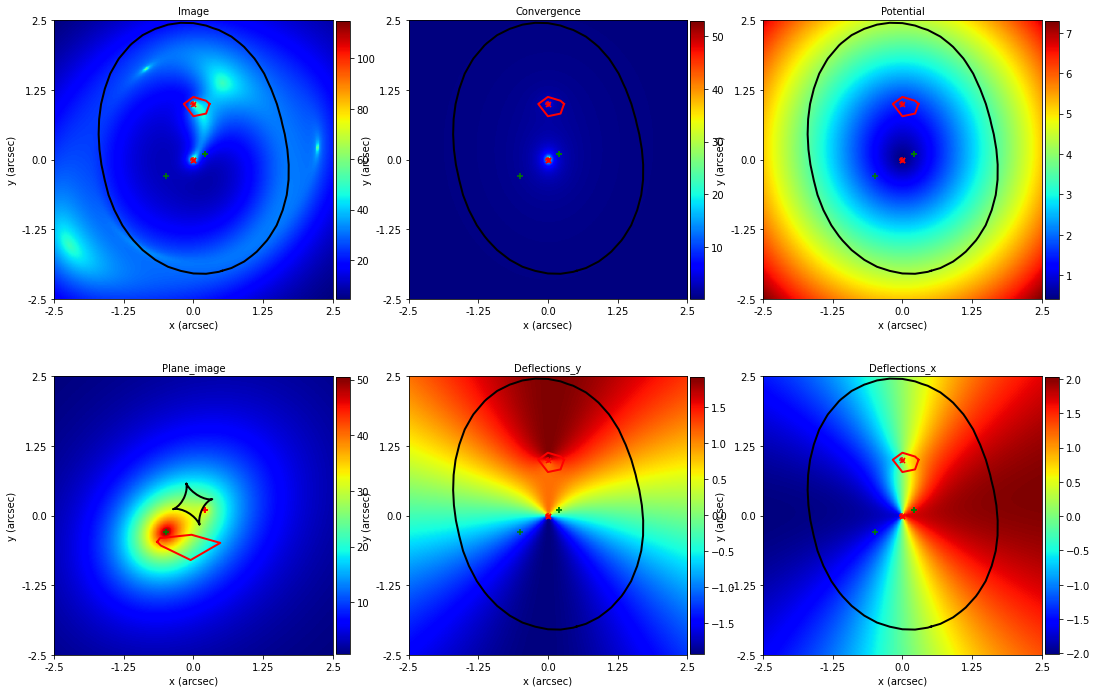

In [24]:
aplt.Tracer.subplot_tracer(tracer=tracer, grid=grid)

In the previous example, we saw that the _Tracer_ had attributes we plotted (e.g. convergence, potential, etc.). Now 
we've input a cosmology and galaxy redshifts, the _Tracer_ has attributes associated with its cosmology.

In [25]:
print("Image-plane arcsec-per-kpc:")
print(tracer.image_plane.arcsec_per_kpc)
print("Image-plane kpc-per-arcsec:")
print(tracer.image_plane.kpc_per_arcsec)
print("Angular Diameter Distance to Image-plane:")
print(tracer.image_plane.angular_diameter_distance_to_earth_in_units(unit_length="kpc"))

print("Source-plane arcsec-per-kpc:")
print(tracer.source_plane.arcsec_per_kpc)
print("Source-plane kpc-per-arcsec:")
print(tracer.source_plane.kpc_per_arcsec)
print("Angular Diameter Distance to Source-plane:")
print(
    tracer.source_plane.angular_diameter_distance_to_earth_in_units(unit_length="kpc")
)

print("Angular Diameter Distance From Image To Source Plane:")
print(
    tracer.angular_diameter_distance_from_image_to_source_plane_in_units(
        unit_length="kpc"
    )
)
print("Lensing Critical convergence:")
print(
    tracer.critical_surface_density_between_planes_in_units(i=0, j=1, unit_length="kpc")
)

Image-plane arcsec-per-kpc:
0.15902722540824196
Image-plane kpc-per-arcsec:
6.288231448626989
Angular Diameter Distance to Image-plane:
1297040.8413879438
Source-plane arcsec-per-kpc:
0.12147853800264662
Source-plane kpc-per-arcsec:
8.231906774991096
Angular Diameter Distance to Source-plane:
1697952.6559876984
Angular Diameter Distance From Image To Source Plane:
725172.02494674
Lensing Critical convergence:
3001935359.329209


And with that, we've completed tutorial 6.